# Programming Exercise 7:
# K-means Clustering and Principal Component Analysis

## Introduction

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

from IPython.display import HTML, display, clear_output

try:
    plt.rcParams["animation.html"] = "jshtml"
except ValueError:
    plt.rcParams["animation.html"] = "html5"

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

%load_ext autoreload
%autoreload 2

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib

Using matplotlib backend: Qt5Agg


## Submission and Grading


After completing each part of the assignment, be sure to submit your solutions to the grader. The following is a breakdown of how each part of this exercise is scored.


| Section | Part                                             | Submitted Function                | Points |
| :-      |:-                                                |:-                                 | :-:    |
| 1       | [Find Closest Centroids](#section1)              | [`findClosestCentroids`](#findClosestCentroids)  |  30    |
| 2       | [Computed Centroid Means](#section2)             | [`computeCentroids`](#computeCentroids)      |  30    |
| 3       | [PCA](#section3)                                 | [`pca`](#pca)                   |  20    |
| 4       | [Project Data](#section4)                        | [`projectData`](#projectData)           |  10    |
| 5       | [Recover Data](#section5)                        | [`recoverData`](#recoverData)           |  10    |
|         | Total Points                                     |                                   |100     |


You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

<div class="alert alert-block alert-warning">
At the end of each section in this notebook, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once.
</div>

## 1 K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After
that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). You will implement the two phases of the K-means algorithm separately
in the next sections.

<a id="section1"></a>
#### 1.1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid. Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

Your task is to complete the code in the function `findClosestCentroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid.
<a id="findClosestCentroids"></a>

In [2]:
def findClosestCentroids(X, centroids) -> np.array:
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
    
    Instructions
    ------------
    Go over every example, find its closest centroid, and store
    the index inside `idx` at the appropriate location.
    Concretely, idx[i] should contain the index of the centroid
    closest to example i. Hence, it should be a value in the 
    range 0..K-1

    Note
    ----
    You can use a for-loop over the examples to compute this.
    """
    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly.
    idx = np.zeros(X.shape[0], dtype=int)

    # ====================== YOUR CODE HERE ======================
    
    m = X.shape[0]

    for i in range(m):
        diff = centroids - X[i];
    
        dists = np.sum(diff**2, 1);
        idx[i] = np.argmin(dists);
    
    # =============================================================
    return idx

Once you have completed the code in `findClosestCentroids`, the following cell will run your code and you should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples.

In [3]:
# Load an example dataset that we will be using
data = loadmat(os.path.join('Data', 'ex7data2.mat'))
X = data['X']

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


*You should now submit your solutions.*

In [44]:
grader[1] = findClosestCentroids
grader.grade()


Submitting Solutions | Programming Exercise k-means-clustering-and-pca

Login (email address): pawan_k@ee.iitr.ac.in
Token: qYHpXDoSRPfLYTpv
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
           Find Closest Centroids (k-Means) |  30 /  30 | Nice work!
           Compute Centroid Means (k-Means) |  30 /  30 | Nice work!
                                        PCA |   0 /  20 | 
                         Project Data (PCA) |   0 /  10 | 
                         Recover Data (PCA) |   0 /  10 | 
                                  --------------------------------
                                            |  60 / 100 |  



<a id="section2"></a>
### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.

You should now complete the code in the function `computeCentroids`. You can implement this function using a loop over the centroids. You can also use a loop over the examples; but if you can use a vectorized implementation that does not use such a loop, your code may run faster.
<a id="computeCentroids"></a>

In [4]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    
    Instructions
    ------------
    Go over every centroid and compute mean of all points that
    belong to it. Concretely, the row vector centroids[i, :]
    should contain the mean of the data points assigned to
    cluster i.

    Note:
    -----
    You can use a for-loop over the centroids to compute this.
    """
    # Useful variables
    m, n = X.shape
    # You need to return the following variables correctly.
    centroids = np.zeros((K, n))
   
    for i in range(K):
         centroids[i] = np.mean(X[idx == i], axis = 0)
   
    return centroids

Once you have completed the code in `computeCentroids`, the following cell will run your code and output the centroids after the first step of K-means.

In [5]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


*You should now submit your solutions.*

In [ ]:
grader[2] = computeCentroids
grader.grade()

### 1.2 K-means on example dataset 

After you have completed the two functions (`findClosestCentroids` and `computeCentroids`), you have all the necessary pieces to run the K-means algorithm. The next cell  will run the K-means algorithm on a toy 2D dataset to help you understand how K-means works. Your functions are called from inside the `runKmeans` function (in this assignment's `utils.py` module). We encourage you to take a look at the function to understand how it works. Notice that the code calls the two functions you implemented in a loop.

When you run the next step, the K-means code will produce an animation that steps you through the progress of the algorithm at each iteration. At the end, your figure should look as the one displayed below.

![](Figures/kmeans_result.png)

In [6]:
# Load an example dataset
data = loadmat(os.path.join('Data', 'ex7data2.mat'))

# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# but in practice you want to generate them automatically, such as by
# settings them to be random examples (as can be seen in
# kMeansInitCentroids).
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])


# Run K-Means algorithm. The 'true' at the end tells our function to plot
# the progress of K-Means
centroids, idx, anim = utils.runkMeans(X, initial_centroids,
                                       findClosestCentroids, computeCentroids, max_iters, True)
anim

limit_output extension: Maximum message size of 10000 exceeded with 578032 characters

### 1.3 Random initialization 

The initial assignments of centroids for the example dataset in the previous cell were designed so that you will see the same figure as that shown in the cell above. In practice, a
good strategy for initializing the centroids is to select random examples from the training set.

In this part of the exercise, you should complete the function `kMeansInitCentroids` with the following code:

```python
# Initialize the centroids to be random examples

# Randomly reorder the indices of examples
randidx = np.random.permutation(X.shape[0])
# Take the first K examples as centroids
centroids = X[randidx[:K], :]
```

The code above first randomly permutes the indices of the examples (using `permute` within the `numpy.random` module). Then, it selects the first $K$ examples based on the random permutation of the indices. This allows the examples to be selected at random without the risk of selecting the same example twice.

*You do not need to make any submission for this part of the exercise*
<a id="kMeansInitCentroids"></a>

In [9]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    
    Instructions
    ------------
    You should set centroids to randomly chosen examples from the dataset X.
    """
    m, n = X.shape
    
    # You should return this values correctly
    centroids = np.zeros((K, n))

    # ====================== YOUR CODE HERE ======================

    centroids = X[np.random.randint(m, size = K), :]
    
    # =============================================================
    return centroids

### 1.4 Image compression with K-means

In this exercise, you will apply K-means to image compression. We will use the image below as an example (property of Frank Wouters with permission to this class).

![](Data/bird_small.png)

In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### 1.4.1 K-means on pixels

In python, images can be read in as follows:

```python
# Load 128x128 color image (bird_small.png)
img = mpl.image.imread(os.path.join('Data', 'bird_small.png'))

# We have already imported matplotlib as mpl at the beginning of this notebook.
```
This creates a three-dimensional matrix `A` whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A[50, 33, 2] gives the blue intensity of the pixel at row 51 and column 34.

The code in the following cell first loads the image, and then reshapes it to create an m x 3 matrix of pixel colors (where m = 16384 = 128 x 128), and calls your K-means function on it.

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the `findClosestCentroids` function. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 x 128 pixel locations, resulting in total size of 128 x 128 x 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 x 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

Finally, you can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, you can replace each pixel location with the mean of the centroid assigned to it. The figure below shows the reconstruction we obtained. 

![](Figures/bird_compression.png)

Even though the resulting image retains most of the characteristics of the original, we also see some compression artifacts.

Run the following cell to compute the centroids and the centroid allocation of each pixel in the image.

In [11]:
# ======= Experiment with these parameters ================
# You should try different values for those parameters
K = 16
max_iters = 10

# Load an image of a bird
# Change the file name and path to experiment with your own images
A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
# ==========================================================

# Divide by 255 so that all values are in the range 0 - 1
A /= 255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = A.reshape(-1, 3)

# When using K-Means, it is important to randomly initialize centroids
# You should complete the code in kMeansInitCentroids above before proceeding
initial_centroids = kMeansInitCentroids(X, K)

# Run K-Means
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids,
                                 max_iters)

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
# Reshape the recovered image into proper dimensions
X_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

*You do not need to make any submissions for this part of the exercise.*

### 1.5 Optional (ungraded) exercise: Use your own image

In this exercise, modify the code we have supplied in the previous cell to run on one of your own images. Note that if your image is very large, then K-means can take a long time to run. Therefore, we recommend that you resize your images to
manageable sizes before running the code. You can also try to vary $K$ to see the effects on the compression.

## 2 Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

### 2.1 Example Dataset

To help you understand how PCA works, you will first start with a 2D dataset which has one direction of large variation and one of smaller variation. The cell below will plot the training data, also shown in here:

In this part of the exercise, you will visualize what happens when you use PCA to reduce the data from 2D to 1D. In practice, you might want to reduce data from 256 to 50 dimensions, say; but using lower dimensional data in this example allows us to visualize the algorithms better.

In [13]:
# Load the dataset into the variable X 
data = loadmat(os.path.join('Data', 'ex7data1.mat'))
X = data['X']

#  Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=1)
plt.axis([0.5, 6.5, 2, 8])
plt.gca().set_aspect('equal')
plt.grid(False)

<a id="section3"></a>
### 2.2 Implementing PCA

In this part of the exercise, you will implement PCA. PCA consists of two computational steps: 

1. Compute the covariance matrix of the data.
2. Use SVD (in python we use numpy's implementation `np.linalg.svd`) to compute the eigenvectors $U_1$, $U_2$, $\dots$, $U_n$. These will correspond to the principal components of variation in the data.

First, you should compute the covariance matrix of the data, which is given by:

$$ \Sigma = \frac{1}{m} X^T X$$

where $X$ is the data matrix with examples in rows, and $m$ is the number of examples. Note that $\Sigma$ is a $n \times n$ matrix and not the summation operator. 

After computing the covariance matrix, you can run SVD on it to compute the principal components. In python and `numpy` (or `scipy`), you can run SVD with the following command: `U, S, V = np.linalg.svd(Sigma)`, where `U` will contain the principal components and `S` will contain a diagonal matrix. Note that the `scipy` library also has a similar function to compute SVD `scipy.linalg.svd`. The functions in the two libraries use the same C-based library (LAPACK) for the SVD computation, but the `scipy` version provides more options and arguments to control SVD computation. In this exercise, we will stick with the `numpy` implementation of SVD.

Complete the code in the following cell to implemente PCA.
<a id="pca"></a>

In [16]:
def pca(X):
    """
    Run principal component analysis.
    
    Parameters
    ----------
    X : array_like
        The dataset to be used for computing PCA. It has dimensions (m x n)
        where m is the number of examples (observations) and n is 
        the number of features.
    
    Returns
    -------
    U : array_like
        The eigenvectors, representing the computed principal components
        of X. U has dimensions (n x n) where each column is a single 
        principal component.
    
    S : array_like
        A vector of size n, contaning the singular values for each
        principal component. Note this is the diagonal of the matrix we 
        mentioned in class.
    
    Instructions
    ------------
    You should first compute the covariance matrix. Then, you
    should use the "svd" function to compute the eigenvectors
    and eigenvalues of the covariance matrix. 

    Notes
    -----
    When computing the covariance matrix, remember to divide by m (the
    number of examples).
    """
    # Useful values
    m, n = X.shape

    # You need to return the following variables correctly.
    U = np.zeros(n)
    S = np.zeros(n)

    # ====================== YOUR CODE HERE ======================
    sigma = (1/m)*(X.T.dot(X))
    U, S, V = np.linalg.svd(sigma)
    
    
    # ============================================================
    return U, S

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In the next cell,  this normalization will be performed for you using the `utils.featureNormalize` function.
After normalizing the data, you can run PCA to compute the principal components. Your task is to complete the code in the function `pca` to compute the principal components of the dataset. 

Once you have completed the function `pca`, the following cell will run PCA on the example dataset and plot the corresponding principal components found similar to the figure below. 

![](Figures/pca_components.png)


The following cell will also output the top principal component (eigenvector) found, and you should expect to see an output of about `[-0.707 -0.707]`. (It is possible that `numpy` may instead output the negative of this, since $U_1$ and $-U_1$ are equally valid choices for the first principal component.)

In [18]:
#  Before running PCA, it is important to first normalize X
X_norm, mu, sigma = utils.featureNormalize(X)

#  Run PCA
U, S = pca(X_norm)

#  Draw the eigenvectors centered at mean of data. These lines show the
#  directions of maximum variations in the dataset.
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=0.25)

for i in range(2):
    ax.arrow(mu[0], mu[1], 1.5 * S[i]*U[0, i], 1.5 * S[i]*U[1, i],
             head_width=0.25, head_length=0.2, fc='k', ec='k', lw=2, zorder=1000)

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

print('Top eigenvector: U[:, 0] = [{:.6f} {:.6f}]'.format(U[0, 0], U[1, 0]))
print(' (you should expect to see [-0.707107 -0.707107])')

Top eigenvector: U[:, 0] = [-0.707107 -0.707107]
 (you should expect to see [-0.707107 -0.707107])


*You should now submit your solutions.*

In [ ]:
grader[3] = pca
grader.grade()

### 2.3 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)}$ (e.g., projecting the data from 2D to 1D). In this part of the exercise, you will use the eigenvectors returned by PCA and
project the example dataset into a 1-dimensional space. In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.

<a id="section4"></a>

#### 2.3.1 Projecting the data onto the principal components

You should now complete the code in the function `projectData`. Specifically, you are given a dataset `X`, the principal components `U`, and the desired number of dimensions to reduce to `K`. You should project each example in `X` onto the top `K` components in `U`. Note that the top `K` components in `U` are given by
the first `K` columns of `U`, that is `Ureduce = U[:, :K]`.
<a id="projectData"></a>

In [33]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when projecting only 
    on to the top K eigenvectors.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). The dataset is assumed to be 
        normalized.
    
    U : array_like
        The computed eigenvectors using PCA. This is a matrix of 
        shape (n x n). Each column in the matrix represents a single
        eigenvector (or a single principal component).
    
    K : int
        Number of dimensions to project onto. Must be smaller than n.
    
    Returns
    -------
    Z : array_like
        The projects of the dataset onto the top K eigenvectors. 
        This will be a matrix of shape (m x k).
    
    Instructions
    ------------
    Compute the projection of the data using only the top K 
    eigenvectors in U (first K columns). 
    For the i-th example X[i,:], the projection on to the k-th 
    eigenvector is given as follows:
    
        x = X[i, :]
        projection_k = np.dot(x,  U[:, k])

    """
    # You need to return the following variables correctly.
    Z = np.zeros((X.shape[0], K))

    # ====================== YOUR CODE HERE ======================
    Ureduced = U[:, :K]
    Z = X.dot(Ureduced)

    
    # =============================================================
    return Z

Once you have completed the code in `projectData`, the following cell will project the first example onto the first dimension and you should see a value of about 1.481 (or possibly -1.481, if you got $-U_1$ instead of $U_1$).

In [34]:
#  Project the data onto K = 1 dimension
K = 1
Z = projectData(X_norm, U, K)
print('Projection of the first example: {:.6f}'.format(Z[0, 0]))
print('(this value should be about    : 1.481274)')

Projection of the first example: 1.481274
(this value should be about    : 1.481274)


*You should now submit your solutions.*

In [ ]:
grader[4] = projectData
grader.grade()

<a id="section5"></a>
#### 2.3.2 Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. Your task is to complete the function `recoverData` to project each example in `Z` back onto the original space and return the recovered approximation in `Xrec`.
<a id="recoverData"></a>

In [35]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the 
    projected data.
    
    Parameters
    ----------
    Z : array_like
        The reduced data after applying PCA. This is a matrix
        of shape (m x K).
    
    U : array_like
        The eigenvectors (principal components) computed by PCA.
        This is a matrix of shape (n x n) where each column represents
        a single eigenvector.
    
    K : int
        The number of principal components retained
        (should be less than n).
    
    Returns
    -------
    X_rec : array_like
        The recovered data after transformation back to the original 
        dataset space. This is a matrix of shape (m x n), where m is 
        the number of examples and n is the dimensions (number of
        features) of original datatset.
    
    Instructions
    ------------
    Compute the approximation of the data by projecting back
    onto the original space using the top K eigenvectors in U.
    For the i-th example Z[i,:], the (approximate)
    recovered data for dimension j is given as follows:

        v = Z[i, :]
        recovered_j = np.dot(v, U[j, :K])

    Notice that U[j, :K] is a vector of size K.
    """
    # You need to return the following variables correctly.
    X_rec = np.zeros((Z.shape[0], U.shape[0]))

    # ====================== YOUR CODE HERE ======================

    X_rec = Z.dot(U[:, :K].T)

    # =============================================================
    return X_rec

Once you have completed the code in `recoverData`, the following cell will recover an approximation of the first example and you should see a value of about `[-1.047 -1.047]`. The code will then plot the data in this reduced dimension space. This will show you what the data looks like when using only the corresponding eigenvectors to reconstruct it. An example of what you should get for PCA projection is shown in this figure: 

![](Figures/pca_reconstruction.png)

In the figure above, the original data points are indicated with the blue circles, while the projected data points are indicated with the red circles. The projection effectively only retains the information in the direction given by $U_1$. The dotted lines show the distance from the data points in original space to the projected space. Those dotted lines represent the error measure due to PCA projection.

In [38]:
X_rec  = recoverData(Z, U, K)
print('Approximation of the first example: [{:.6f} {:.6f}]'.format(X_rec[0, 0], X_rec[0, 1]))
print('       (this value should be about  [-1.047419 -1.047419])')

#  Plot the normalized dataset (returned from featureNormalize)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1], 'bo', ms=8, mec='b', mew=0.5)
ax.set_aspect('equal')
ax.grid(False)
plt.axis([-3, 2.75, -3, 2.75])

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

Approximation of the first example: [-1.047419 -1.047419]
       (this value should be about  [-1.047419 -1.047419])


*You should now submit your solutions.*

In [ ]:
grader[5] = recoverData
grader.grade()

### 2.4 Face Image Dataset

In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset `ex7faces.mat` contains a dataset `X` of face images, each $32 \times 32$ in grayscale. This dataset was based on a [cropped version](http://conradsanderson.id.au/lfwcrop/) of the [labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/) dataset. Each row of `X` corresponds to one face image (a row vector of length 1024). 

The next cell will load and visualize the first 100 of these face images similar to what is shown in this figure:

![Faces](Figures/faces.png)

In [39]:
#  Load Face dataset
data = loadmat(os.path.join('Data', 'ex7faces.mat'))
X = data['X']

#  Display the first 100 faces in the dataset
utils.displayData(X[:100, :], figsize=(8, 8))

#### 2.4.1 PCA on Faces

To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix `X`.  After running PCA, you will obtain the principal components of the dataset. Notice that each principal component in `U` (each column) is a vector of length $n$ (where for the face dataset, $n = 1024$). It turns out that we can visualize these principal components by reshaping each of them into a $32 \times 32$ matrix that corresponds to the pixels in the original dataset. 

The following cell will first normalize the dataset for you and then run your PCA code. Then, the first 36 principal components (conveniently called eigenfaces) that describe the largest variations are displayed. If you want, you can also change the code to display more principal components to see how they capture more and more details.

In [42]:
#  normalize X by subtracting the mean value from each feature
X_norm, mu, sigma = utils.featureNormalize(X)

#  Run PCA
U, S = pca(X_norm)

#  Visualize the top 36 eigenvectors found
utils.displayData(U[:, :36].T, figsize=(8, 8))

#### 2.4.2 Dimensionality Reduction

Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm.

The next cell will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector $z^{(i)} \in \mathbb{R}^{100}$. To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset.

In [43]:
#  Project images to the eigen space using the top k eigenvectors 
#  If you are applying a machine learning algorithm 
K = 100
Z = projectData(X_norm, U, K)

print('The projected data Z has a shape of: ', Z.shape)

The projected data Z has a shape of:  (5000, 100)


In the next cell, an approximate recovery of the data is performed and the original and projected face images
are displayed similar to what is shown here:

<table>
    <tr>
        <td><img src="Figures/faces_original.png" width="300"></td>
        <td><img src="Figures/faces_reconstructed.png" width="300"></td>
    </tr>
</table>

From the reconstruction, you can observe that the general structure and appearance of the face are kept while the fine details are lost. This is a remarkable reduction (more than 10x) in the dataset size that can help speed up your learning algorithm significantly. For example, if you were training a neural network to perform person recognition (given a face image, predict the identity of the person), you can use the dimension reduced input of only a 100 dimensions instead of the original pixels.

In [45]:
#  Project images to the eigen space using the top K eigen vectors and 
#  visualize only using those K dimensions
#  Compare to the original input, which is also displayed
K = 100
X_rec  = recoverData(Z, U, K)

# Display normalized data
utils.displayData(X_norm[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Original faces')

# Display reconstructed data from only k eigenfaces
utils.displayData(X_rec[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Recovered faces')
pass

### 2.5 Optional (ungraded) exercise: PCA for visualization

In the earlier K-means image compression exercise, you used the K-means algorithm in the 3-dimensional RGB space. We reduced each pixel of the RGB image to be represented by 16 clusters. In the next cell, we have provided code to visualize the final pixel assignments in this 3D space. Each data point is colored according to the cluster it has been assigned to. You can drag your mouse on the figure to rotate and inspect this data in 3 dimensions.

In [46]:
# this allows to have interactive plot to rotate the 3-D plot
# The double identical statement is on purpose
# see: https://stackoverflow.com/questions/43545050/using-matplotlib-notebook-after-matplotlib-inline-in-jupyter-notebook-doesnt
%matplotlib notebook
%matplotlib notebook
from matplotlib import pyplot


A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
A /= 255
X = A.reshape(-1, 3)

# perform the K-means clustering again here
K = 16
max_iters = 10
initial_centroids = kMeansInitCentroids(X, K)
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids, max_iters)

#  Sample 1000 random indexes (since working with all the data is
#  too expensive. If you have a fast computer, you may increase this.
sel = np.random.choice(X.shape[0], size=1000)

fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[sel, 0], X[sel, 1], X[sel, 2], cmap='rainbow', c=idx[sel], s=8**2)
ax.set_title('Pixel dataset plotted in 3D.\nColor shows centroid memberships')
pass

It turns out that visualizing datasets in 3 dimensions or greater can be cumbersome. Therefore, it is often desirable to only display the data in 2D even at the cost of losing some information. In practice, PCA is often used to reduce the dimensionality of data for visualization purposes. 

In the next cell,we will apply your implementation of PCA to the 3-dimensional data to reduce it to 2 dimensions and visualize the result in a 2D scatter plot. The PCA projection can be thought of as a rotation that selects the view that maximizes the spread of the data, which often corresponds to the “best” view.

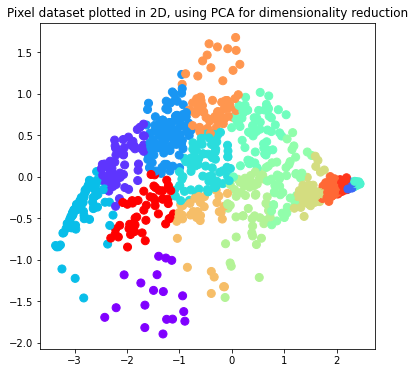

In [47]:
# Subtract the mean to use PCA
X_norm, mu, sigma = utils.featureNormalize(X)

# PCA and project the data to 2D
U, S = pca(X_norm)
Z = projectData(X_norm, U, 2)

# Reset matplotlib to non-interactive
%matplotlib inline

fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.scatter(Z[sel, 0], Z[sel, 1], cmap='rainbow', c=idx[sel], s=64)
ax.set_title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')
ax.grid(False)
pass